```
Copyright 2018 FAU-iPAT (http://ipat.uni-erlangen.de/)
```

# Tucana 5.4 result demonstration
This notebook demonstrates the results of the Tucana 5.4 neural network. Therefore the performance is compared to two other methods of peak detection:

* Inclination change based peak detection from the peakutils package
* CWT based peak detection from the SciPy package

The demonstrations are based on a simple constructed signal and the artifical training data. Additionally results for real measurements are also shown.

In [1]:
import math
import peakutils
import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_json
from scipy.signal import find_peaks_cwt

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%run '../libs/complex2features.py'
%run '../libs/tools.py'

## Load a sample from the artifical dataset
The sample data are already preprocessed. There is one list of the time series data and one list with the peak location answer vector.

In [4]:
adata = np.load('../data/sample_signal.npy')
aanswer = np.load('../data/sample_answer.npy')

Number of samples = 1024
Signal length = 512


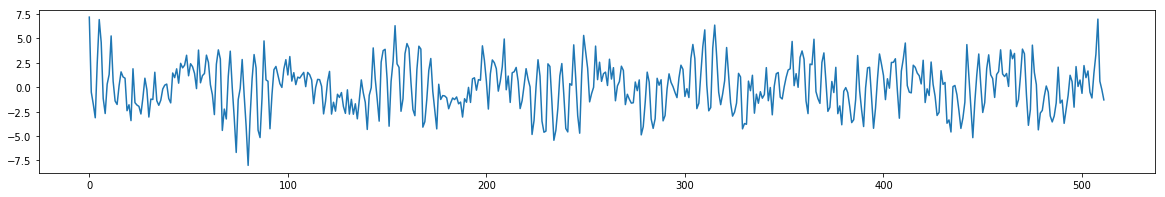

In [5]:
print("Number of samples = {}\nSignal length = {}".format(adata.shape[0], adata.shape[1]))
plt.figure(figsize=(20,3))
plt.plot(adata[3])
plt.show()

## Load the dataset of real measurements
The measured data and according setup parameters are contained within a single numpy list.

In [6]:
mdata = np.load('../data/eccentric_screw_pump.npy')

Dictionary keys of each entry = dict_keys(['average', 'pressure', 'torque'])
System parameters of each entry = dict_keys(['pressure_bar', 'pressure_absolute_bar', 'rotation_hz', 'rotation_motor_hz'])
Time series data = dict_keys(['data', 'samples', 'samplerate'])


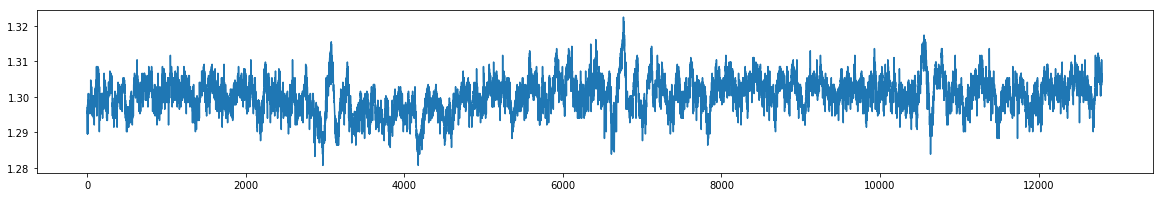

In [7]:
print('Dictionary keys of each entry = {}'.format(mdata[0].keys()))
print('System parameters of each entry = {}'.format(mdata[0]['average'].keys()))
print('Time series data = {}'.format(mdata[0]['pressure'].keys()))
plt.figure(figsize=(20,3))
plt.plot(mdata[0]['pressure']['data'])
plt.show()

## Load the trained neural network

In [8]:
with open('../models/tucana_v5.4.json') as file:
    json = file.read()
model = model_from_json(json)
model.load_weights('../results/tucana5.4_weights.hdf5')

## Define a simple signal generation function
This method generates a simple signal consisting of three single oscillations plus some noise which strength is set by the functions parameter. The function is used to demonstrate the influence of increasily strong noise.

In [9]:
def make_signal(noise=0.0):
    signal = 2.0 * np.pi * np.arange(512) / 512.0
    signal = 1.0 * np.sin(20.17 * signal + 0.1) + 0.75 * np.cos(150.1 * signal + 0.5) + 0.5 * np.sin(110.625 * signal + 3.2)
    np.random.seed(42)
    noise = np.random.uniform(0.0, noise, 512)
    return signal + noise

## Description of the plot format
The following plots demonstrating the results will all be using the same plot format. This format is demonstrated in the following plot. The blue curve shows the fourier transformation of the signal, with the normalized amplitude plotted over the frequency. The vertical, red, dottet lines represent the predictions of the according algorithm where it locates the peaks of the signal. The smaller, vertical, green lines below the curve represent the ground truth, where the locations of the peaks actually are.

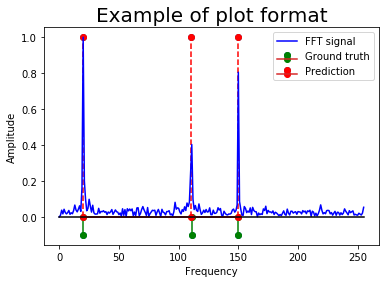

In [10]:
Tools.plot_prediction(Tools.fft(make_signal(1.0), normalize=True), prediction=[20,110,150], answer=[20,111,150])
plt.title('Example of plot format', fontsize=20)
plt.show()

## Noise and threshold dependency of the peakutils package
This sections demonstrates the influence of the amount noise on the threshold tuning parameter of the peak detection function from the peakutils package. The method basically scans for changes in the sign of inclination of the curve. Wherever such change is found, and the signal value at the location is above the threshold a peak is detected.

In [11]:
# Different noise levels to be applied from left to right
noises = [0.0, 2.0, 4.0, 6.0, 8.0]
# Different thresholds to be applied from top to bottom
thresholds = [0.2, 0.275, 0.325, 0.4]

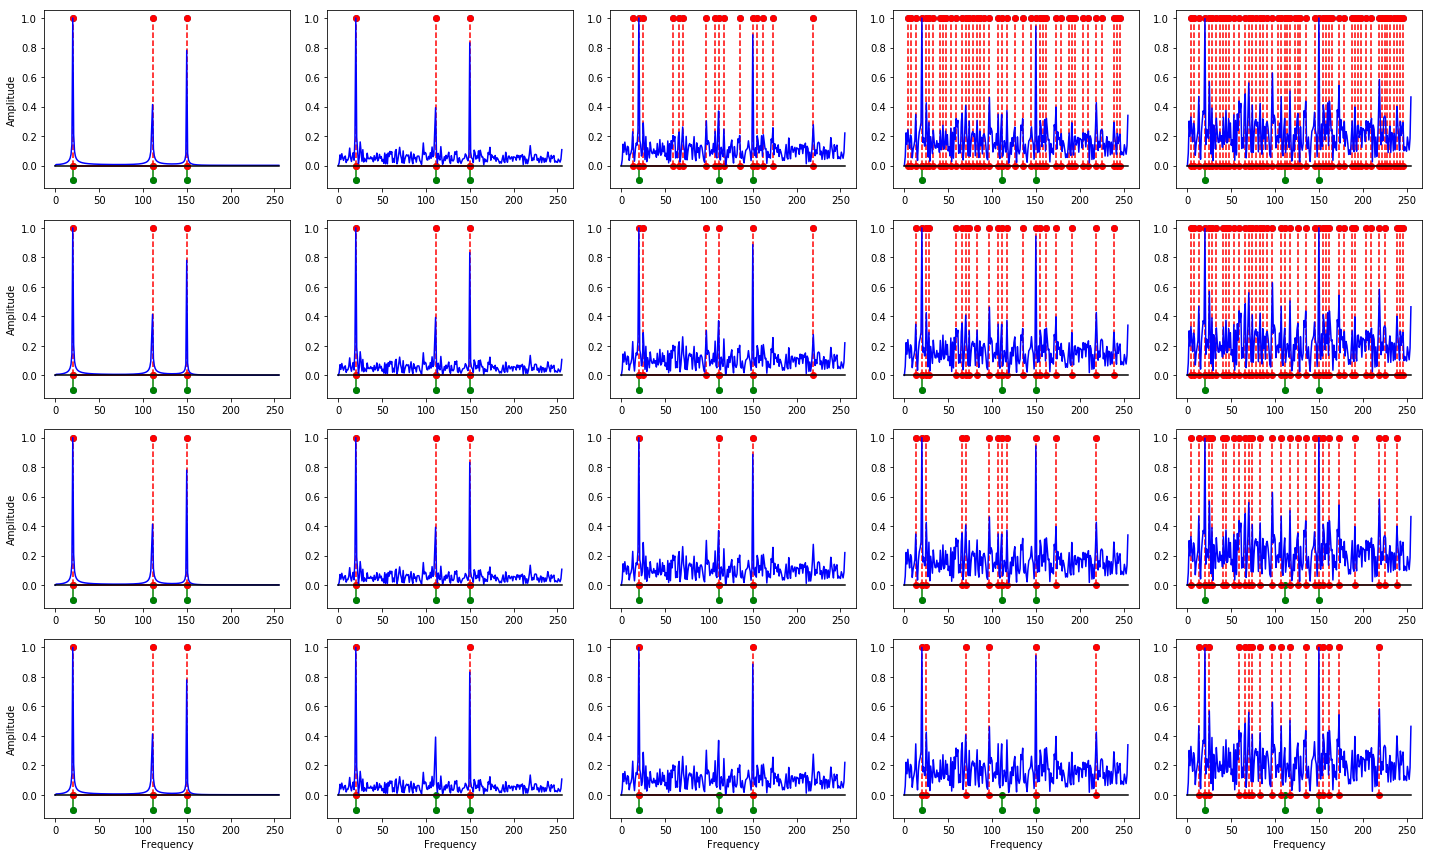

In [12]:
plt.figure(figsize=(4*len(noises),3*len(thresholds)))
for idx, noise in enumerate(noises):
    for idy, threshold in enumerate(thresholds):
        plt.subplot(len(thresholds), len(noises), idy*len(noises)+idx+1)
        signal = make_signal(noise)
        data = Tools.fft(signal, normalize=True)
        peaks = peakutils.indexes(np.abs(data), thres=threshold, min_dist=2)
        Tools.plot_prediction(
            data, 
            prediction=peaks, 
            answer=[20,111,150],
            xlabel=(idy == 3), ylabel=(idx == 0), legend=False
        )
plt.tight_layout()
plt.show()

The above produced graphic demonstrates the influence of the noise (low to high from left to right) and the cut-off threshold parameter (low to high from top to bottom). In the first column can be seen that for no noise the peakutils function works over a wide range of threshold values. But already in the second column the picture at the bottom demonstrates, that through the additional effect of the noise, one peak gets a little bit smaller and thus falls below the threshold. This already demonstrates that the result of this method heavily depends on the choice of the threshold parameter.

This gets even more obvious in columns farther right with increased noise. It can be clearly seen, that the amount of peaks detected, depends massively on the chosen threshold parameter (top to bottom). As long as the amplitude of the ground truth peaks is larger than the amplitude of the largest noise peak, one can find a threshold to get only the ground truth peaks. The moment the noise gets in similar ranges as the ground truth peaks, this method is more or less use-less.

This can for example be seen in the fourth column. Comparing the two pictures at the bottom of the column, one can see, that in the upper of the two pictures (threshold = 0.325), all three ground truth peaks are still recognized. Additionally some of the larger noise peaks are also detected as peaks. In the lower picture (threshold = 0.4), one of the ground truth peaks is not recognized anymore, but still there are some detected peaks at locations where there is only noise and no real peaks.

In the column to the right one can see, that above a certain amount of noise within the signal, no matter how the threshold is chosen, the results are more or less meaningless. Even with a very high threshold so many peaks are detected, that getting useful information from this detection is just as hard as without the algorithm. Especially since explained in the previous paragraph, not only are there a lot of additional peaks detected at wrong locations, but also some of the ground truth peaks might not be included in the answer anymore.

Thus this does only work up to a certain amount of noise. And even below this level of noise, the selection of the threshold parameter is critical to the results: too high thresholds lose ground truth peak, too low thresholds include false noise peaks. For this example the threshold can be chosen optimally, since the results can be compared to the ground truth. In real measurements where the ground truth is unknwon, it is much harder to choose a good threshold, since there is no way to decide whether a detected peak is real or just noise.

## Noise and certainty dependency of the Tucana 5.4 neural network
This section demonstrates in a similar manner how to results of the tucana neural network depend on the amount of noise and its certainty threshold parameter.

In [13]:
# Different noise levels to be applied from left to right
noises = [0.0, 2.0, 4.0, 6.0, 8.0]
# Different certainty thresholds to be applied from top to bottom
thresholds = [0.3, 0.4, 0.5, 0.6]

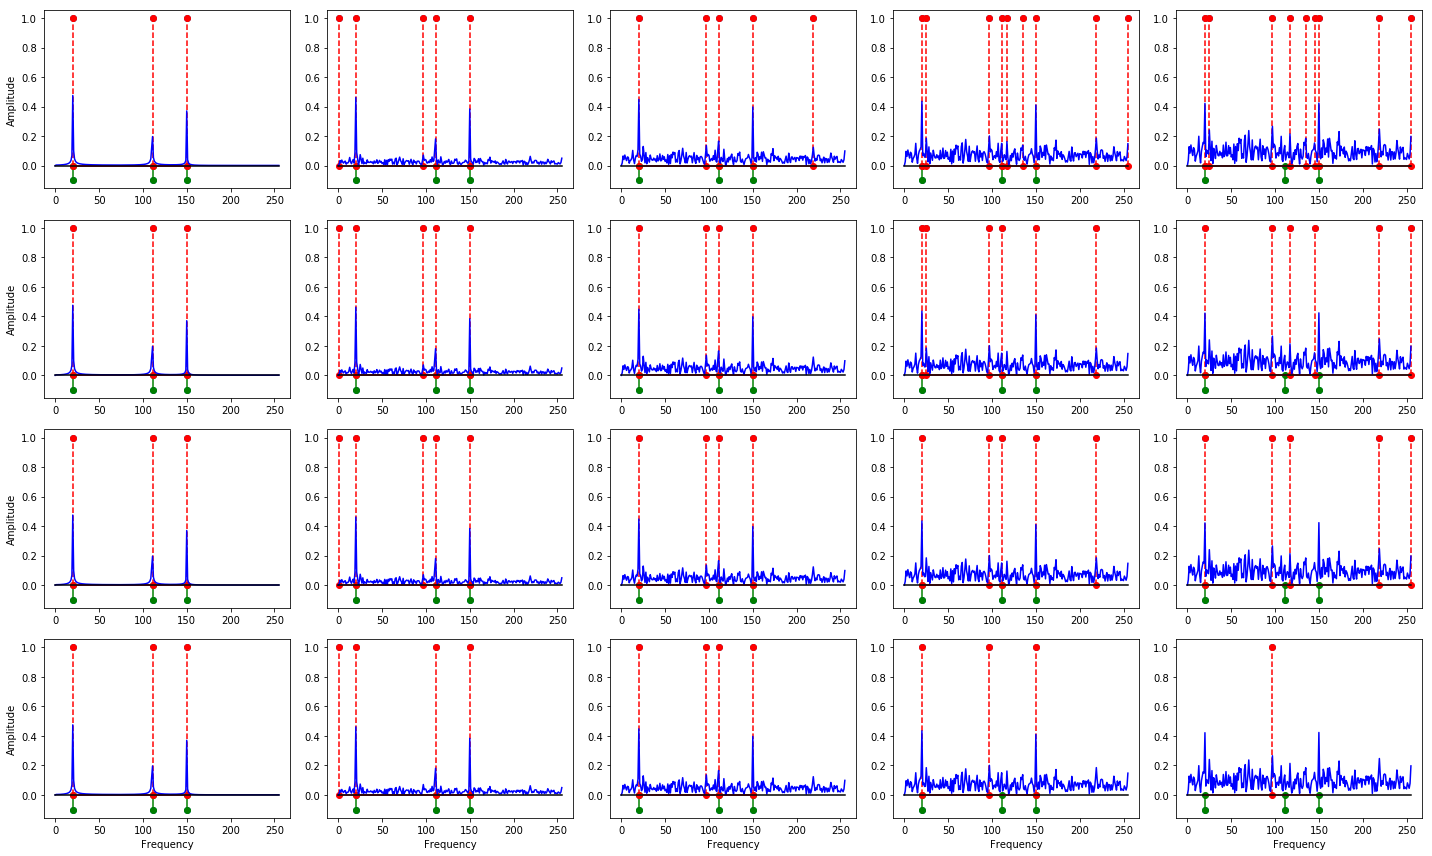

In [14]:
plt.figure(figsize=(4*len(noises),3*len(thresholds)))
for idx, noise in enumerate(noises):
    for idy, certainty in enumerate(thresholds):
        plt.subplot(len(thresholds), len(noises), idy*len(noises)+idx+1)
        signal = make_signal(noise)
        data = Tools.fft(signal)
        hdata = Tools.fft(signal * np.hanning(len(signal)))
        features = c2f([data, hdata], normalize=0, real=True, imaginary=True, absolute=True)
        pred = Tools.cleanup(Tools.predict(model, features))
        Tools.plot_prediction(
            data, 
            prediction=(pred * (pred > certainty)), 
            answer=[20,111,150],
            xlabel=(idy == 3), ylabel=(idx == 0), legend=False
        )
plt.tight_layout()
plt.show()

The above produced graphic demonstrates the influence of the noise (low to high from left to right) and the certainty threshold parameter (low to high from top to bottom). Probably the most obvious observation is that compared to the peakutils method, the tucana neural network produces much less false positive peak detections. Similar to the peakutils method, the tucana predictions can't really handle the case with the most noise in the column to the right. Just like for peakutils, the results in this case are not very reliable.

In all the other cases the tucana neural network predictions provide quite consistent results over the range of different noise levels. There are some additional noise peaks that get detected as peaks with increasing noise level, but that is much less than for even the best threshold of the peakutils method. Additionally the tucana predictions are mostly independent of the chosen certainty threshold for the neural network. Only on the lowest row, where the certainty threshold is chosen quite large, one of the ground truth peaks is lost at high noise levels.

Overall the results show, that the tucana neural network is mostly independent of its certainty threshold (as long as its in a reasonable range) and produces consistent results within a large range of noise levels. Only for very large noise levels this method does not work, just like the peakutils function. For all other cases there are almost no false negatives and the false positives are much less than for the peakutils function. And these result can be achieved with a fixed pre-set certainty threshold which is independent of the expected noise level, in contrast to the peakutils function where the threshold parameter needs to be hand-crafted based on the noise level of each individual signal. Thus in total these simple examples demonstrate the improved performance of the tucana neural network for peak detection compared to the peakutils function.

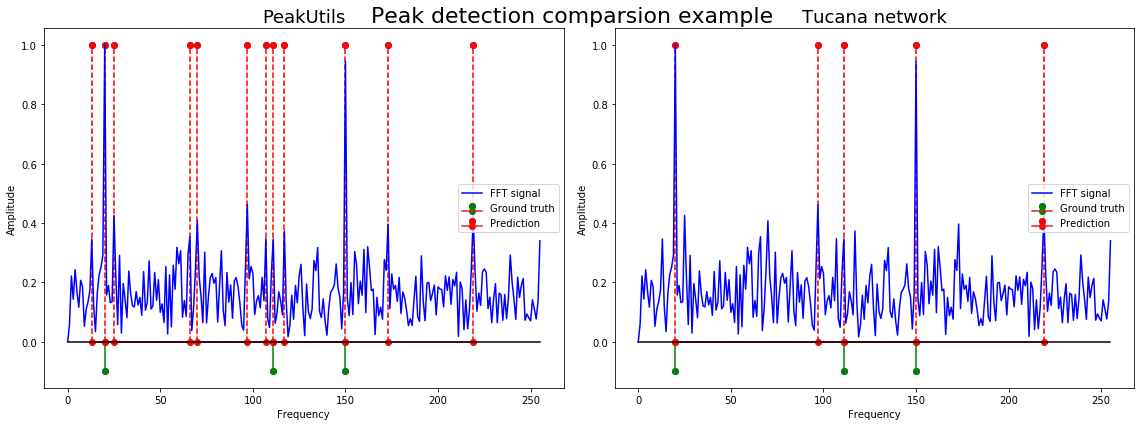

In [15]:
plt.figure(figsize=(16,6))
plt.suptitle('Peak detection comparsion example', fontsize=22)

plt.subplot(1,2,1)
plt.title('PeakUtils', fontsize=18)
signal = make_signal(6.0)
data = Tools.fft(signal, normalize=True)
peaks = peakutils.indexes(np.abs(data), thres=0.325, min_dist=2)
Tools.plot_prediction(data, prediction=peaks, answer=[20,111,150])

plt.subplot(1,2,2)
plt.title('Tucana network', fontsize=18)
features = c2f(
    [Tools.fft(signal), Tools.fft(signal * np.hanning(len(signal)))],
    normalize=0, real=True, imaginary=True, absolute=True
)
pred = Tools.cleanup(Tools.predict(model, features))
Tools.plot_prediction(data, prediction=(pred * (pred > 0.5)), answer=[20,111,150])

plt.tight_layout()
plt.show()

## Peak detection method comparison for training data
This section provides some comparative examples of the tucana neural network predictions, the peakutils function and the CWT based peak detection from the SciPy package. For this purpose a helper plotting function is defined next.

In [16]:
def plot_comparison(signal, answer, pu_threshold, model, t_threshold, cwt_params, xlimit=None, savefile=None):
    plt.figure(figsize=(20,4))
    
    plt.subplot(1,3,1)
    plt.title('PeakUtils', fontsize=18)
    data = Tools.fft(signal, normalize=True)
    peaks = peakutils.indexes(np.abs(data), thres=pu_threshold, min_dist=2)
    Tools.plot_prediction(data, prediction=peaks, answer=answer, legend=None)
    if xlimit is not None: plt.xlim(xlimit[0], xlimit[1])
    
    plt.subplot(1,3,2)
    plt.title('Tucana network', fontsize=18)
    data = Tools.fft(signal)
    hdata = Tools.fft(signal * np.hanning(len(signal)))
    features = c2f(
        [data, hdata],
        normalize=0, real=True, imaginary=True, absolute=True
    )
    pred = Tools.cleanup(Tools.predict(model, features))
    data = Tools.fft(signal, normalize=True)
    Tools.plot_prediction(data, prediction=(pred * (pred > t_threshold)), answer=answer, legend=None)
    if xlimit is not None: plt.xlim(xlimit[0], xlimit[1])

    plt.subplot(1,3,3)
    plt.title('SciPy CWT', fontsize=18)
    data = Tools.fft(signal, normalize=True)
    peaks = find_peaks_cwt(
        np.abs(data),
        widths = cwt_params[0],
        max_distances = cwt_params[1],
        gap_thresh = cwt_params[2],
        min_length = cwt_params[3],
        min_snr = cwt_params[4],
        noise_perc = cwt_params[5]
    )
    Tools.plot_prediction(data, prediction=peaks, answer=answer, legend=None)
    if xlimit is not None: plt.xlim(xlimit[0], xlimit[1])
    
    plt.tight_layout()
    if savefile is not None: plt.savefig(savefile, forrmat='png', dpi=50)
    plt.show()

For the following examples being shown, some data from the artifical dataset is chosen. A single signal is chosen first for which the parameters of the different methods get optimized manually. Additionally a list of further signals is selected, which are then tested using the same parameters. This is done to demonstrate that the classical methods need their parameters tuned for each example separately, while for the neural network based method, one and the same certainty threshold works for a wide range of different signals.

In [17]:
# Sample ID to pick
idx = 15
idxs = [3,10,12,17,18,28,37]

# PeakUtils parameters
pu_threshold = 0.183

# Tucana neural network parameters
t_certainty = 0.25

# SciPy CWT function parameters
cwt_widths = np.arange(1,5)
cwt_max_distances = cwt_widths / 4  # Default Value
cwt_gap_thresh = 2  # Default value
cwt_min_length = len(cwt_widths)/4  # Default value
cwt_min_snr = 1.35
cwt_noise_perc = 1.0
cwt_params = (cwt_widths, cwt_max_distances, cwt_gap_thresh, cwt_min_length, cwt_min_snr, cwt_noise_perc)

Above the parameters for the different models where chosen in such a way, that the methods produce good results on the one chosen example shown below. As seen in previous sections, both methods, the tucana neural network and the peakutils function, each require one parameter to be chosen. Their different levels of dependency on their parameter was already demonstrated.

The third method presented here is a CWT based peak detection method from the SciPy package. It can already be seen from the list of parameters above, that this method has quite a few parameters to set. Thus no detailed study on the influence of each of them was presented here. But for the following example the parameters for the CWT based method were also chosen such that a reasonably good result could be achieved.

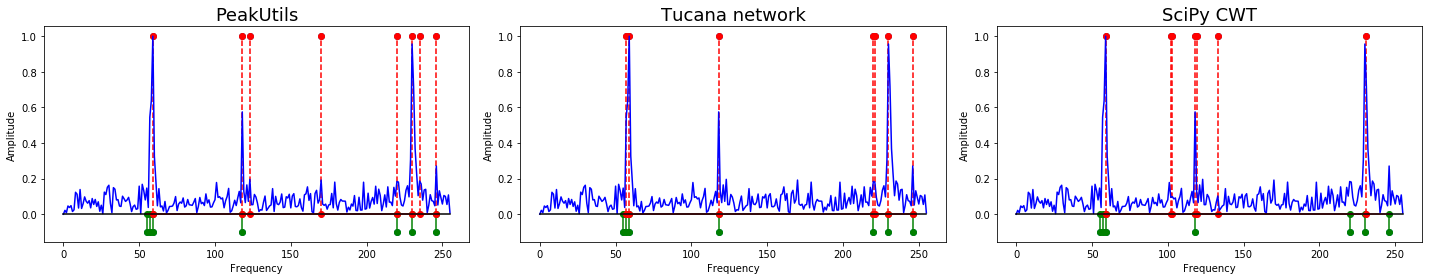

In [18]:
# Plot results for the example the parameters were optimized for
#plot_comparison(adata[idx], aanswer[idx], pu_threshold, model, t_certainty, cwt_params, savefile='../docs/readme/tucana_results.png')
plot_comparison(adata[idx], aanswer[idx], pu_threshold, model, t_certainty, cwt_params)

Already this one example demonstrates that the tucana neural network is the easiest to set the parameters for. The results are quite persistent along a wide range of certainty parameter values. Only the smallest of the peaks in the signal can get ignored if the certainty threshold is chosen too high.

For the PeakUtils function no really good threshold parameter can be found at all for this case. The current value of the parameter was chose as small as possible without loosing the detection of a ground truth peak. A larger value would increase the number of false positives, a smaller value would lose ground truth peaks, while still keeping some of the false positives. Thus the chosen value is the best possible compromise of the threshold parameter for this case. As already mentioned before in real measurements where the ground truth is not known, the choice of a good threshold value is even more complicated.

The last method, the CWT based function from the SciPy package, requires a whole bunch of parameters. The here presented parameters are the best combination that could be found by manually trying different combinations.

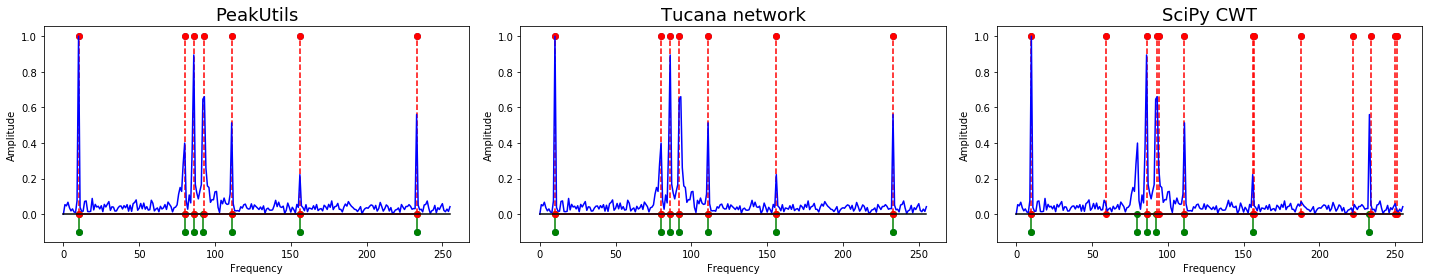

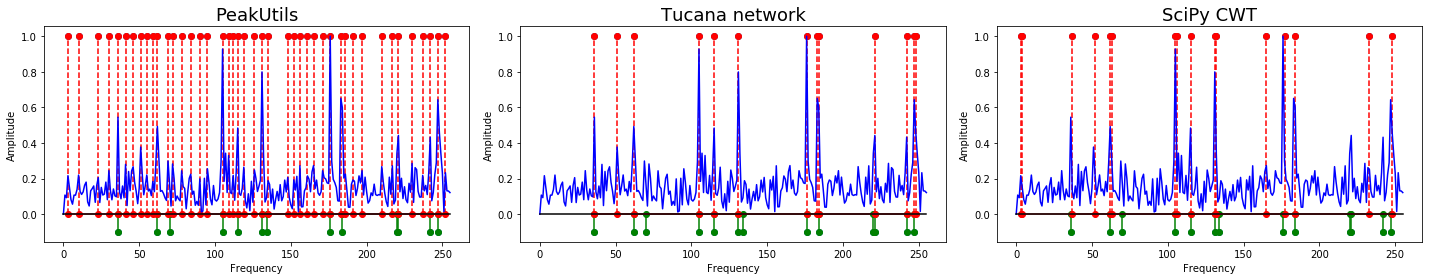

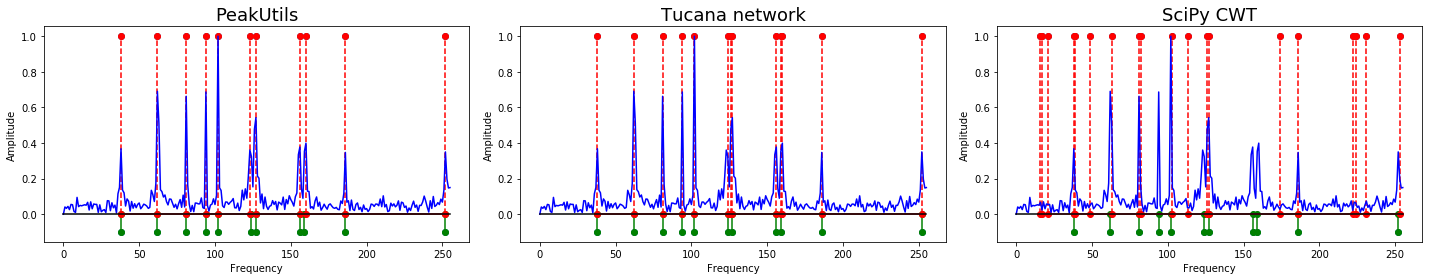

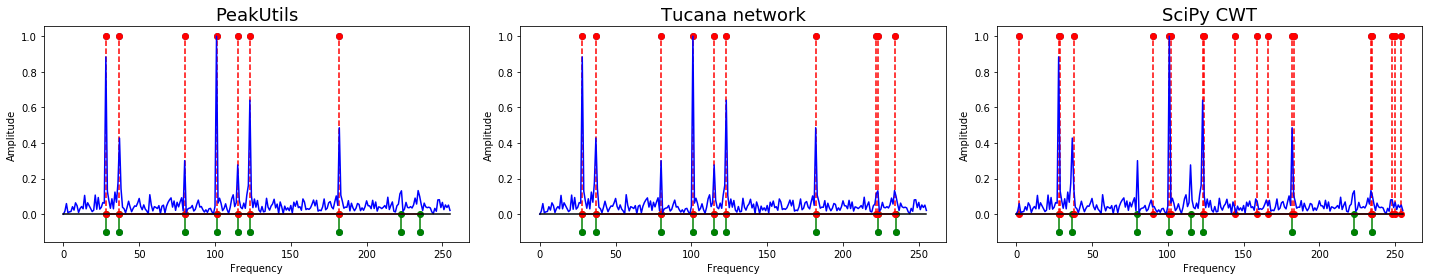

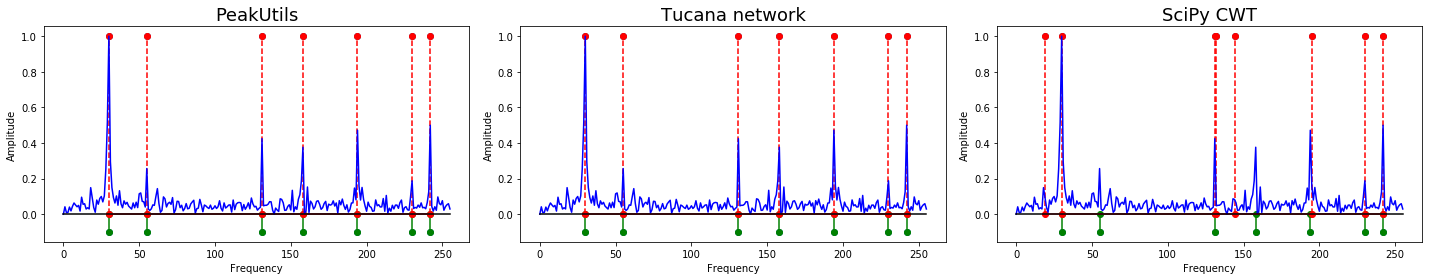

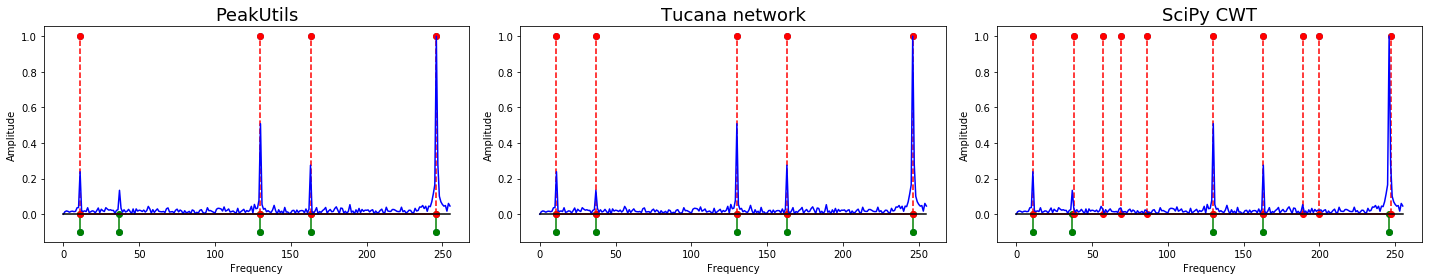

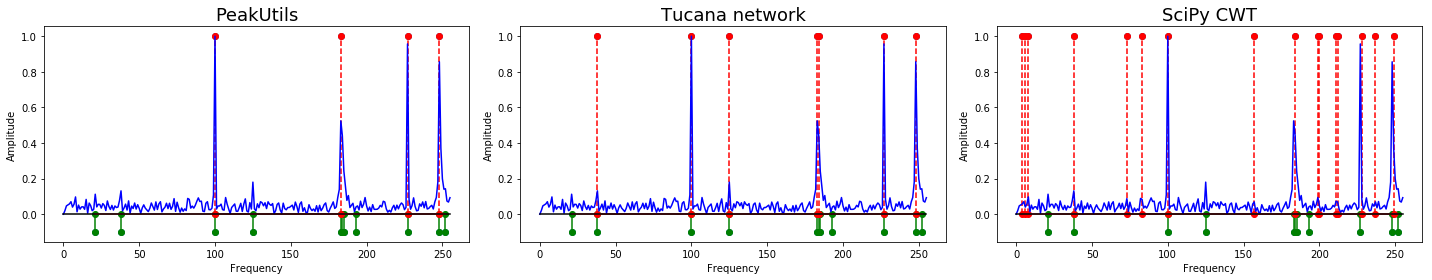

In [19]:
# Plot other comparison graphs using the same parameters
for idx in idxs:
    plot_comparison(adata[idx], aanswer[idx], pu_threshold, model, t_certainty, cwt_params)

Finally the picture above demonstrates what happens when the three different methods are applied to other data, with the exact same parameters, without any readjustment to the specific case. The results show that without changing the parameters, the tucana method performs the most reliable across the different data entries. While for the other two methods there are cases where they perform extremly poor, the tucana method provides reasonable results for all the cases. Thus for practical applications where the ground truth is not known, and thus the tuning of the parameters for the peakutils and CWT based function is a lot harder, the tucana methods provides an easier method which does not require fine-tuning of any parameters.

## Application to real measurements
This sections shows an example of applying the different peak detection methods to real measurements of an excentric screw pump. As mentioned before for those measurements there is no ground truth available, thus no real objective measurement of result quality.

In [20]:
# Sample ID to pick and downsampling rates
idx = 17
downsampling = [2,5,10,20]

# PeakUtils parameters
pu_threshold = 0.07

# Tucana neural network parameters
t_certainty = 0.1

# SciPy CWT function parameters
cwt_widths = np.arange(1,5)
cwt_max_distances = cwt_widths / 4  # Default Value
cwt_gap_thresh = 2  # Default value
cwt_min_length = len(cwt_widths)/4  # Default value
cwt_min_snr = 0.9
cwt_noise_perc = 11.5
cwt_params = (cwt_widths, cwt_max_distances, cwt_gap_thresh, cwt_min_length, cwt_min_snr, cwt_noise_perc)

Again the parameters in the cell above where chosen to produce the most reasonable results for the testcase shown on the picture below. The expected peaks should be at the frequency of the pump rotation speed and its harmonics. Since the system where the measurements were performed does not contain any other source of oscillations (except for resonances), those should most likely be the only peaks found. The measurement results shown here contain a very low noise level, thus the detection of the peaks should be comparable easy.

/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


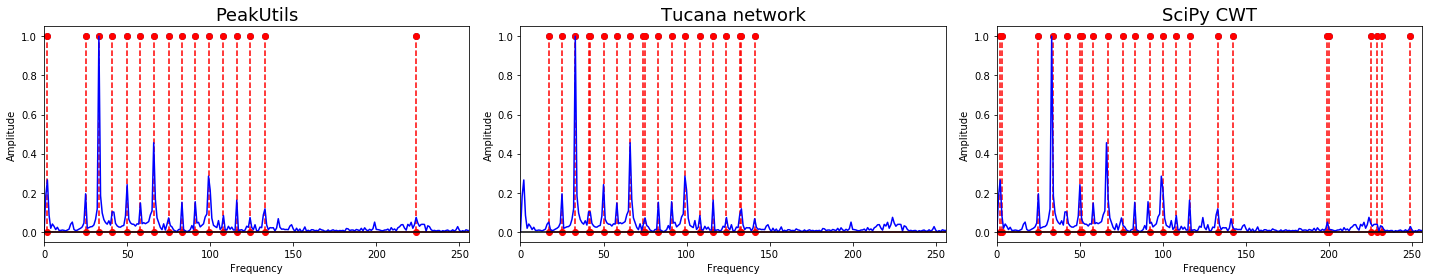

In [21]:
# Plot results for the measurements the parameters were optimized for
data = mdata[idx]['pressure']['data']
plot_comparison(data, None, pu_threshold, model, t_certainty, cwt_params, xlimit=(0,256))

The results of the different methods in the picture above show, that for accordingly chosen parameters all three methods produce reasonable results. The following pictures will demonstrate what happens if the measurement data contains more noise. To incrase the noise level in the fourier transformation, the measurement data are downsampled, which will increase the noise in the fourier spectrum. Pictures for different levels of downsampling are shown below.

/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


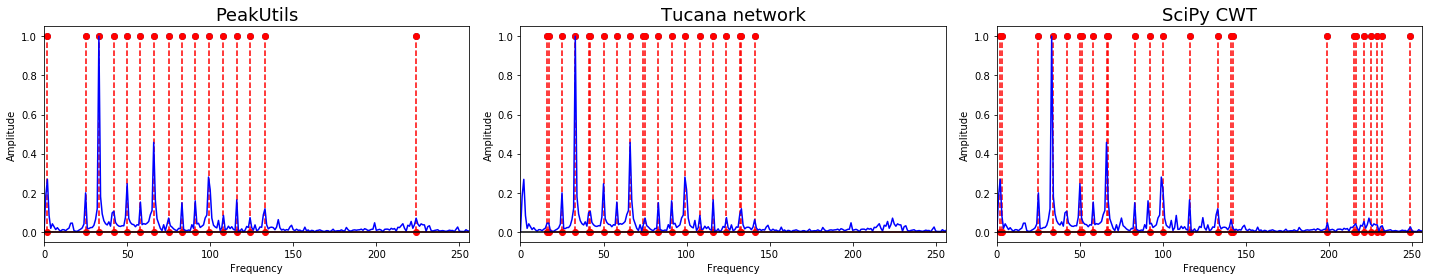

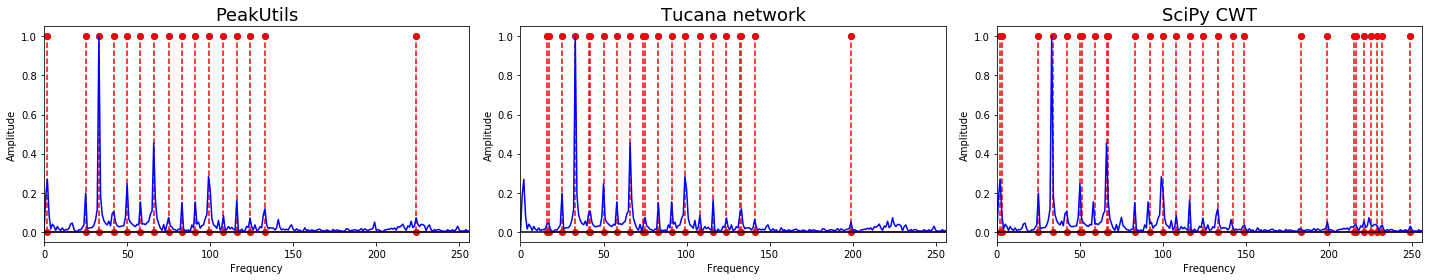

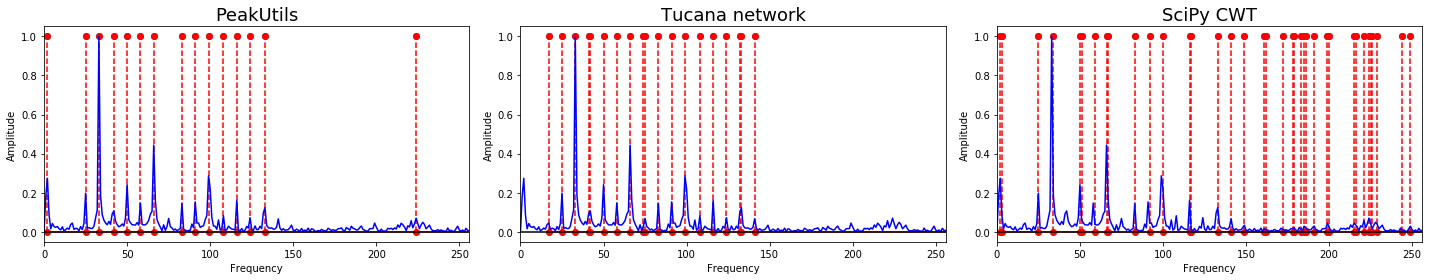

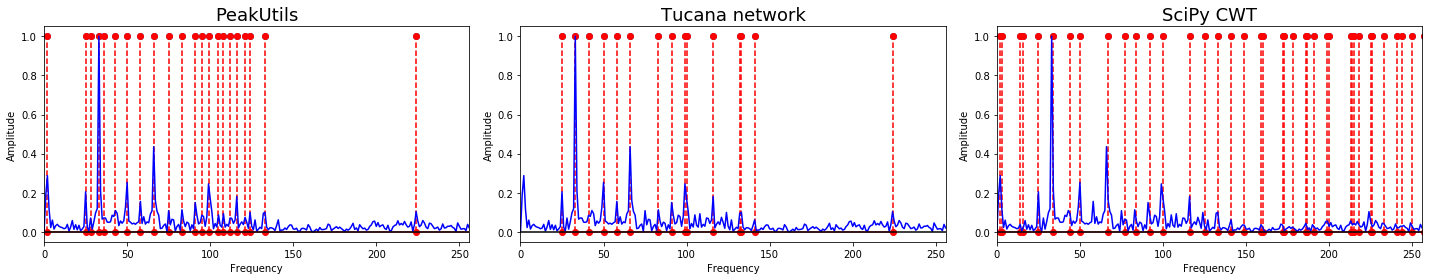

In [22]:
# Plot results for different downsampled versions of the measurement data (increase noise level)
for rate in downsampling:
    data = mdata[idx]['pressure']['data']
    data = data[::rate]
    plot_comparison(data, None, pu_threshold, model, t_certainty, cwt_params, xlimit=(0,256))

The series of pictures for different noise levels on real measurements demonstrates again, that the tucana methods performs the most reliable of the three methods. While the lowest peaks are not found anymore for the highest noise level, the results of the tucana methods are still quite consistent for all noise levels.

On the other side, the peakutils and CWT based methods both do not only lose peaks found at lower noises, but they also produce alot of additional false positives with increasing noise.

## Conclusion
In total the results shown in this notebook demonstrated the capabilities of the tucana neural network for peak detection in fourier spectra. For all the shown test cases (simple signal, training data and real measurements), the tucana method performed at least on par or even better than the other two methods. At the same time the tucana methods is alot less dependent on fine-tuning of its parameter, which makes it also easier to use. Thus in total this method seems to be an improvement compared to the PeakUtils inclination based peak detection method and the SciPy CWT based method.

```
Copyright 2018 FAU-iPAT (http://ipat.uni-erlangen.de/)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```